#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Sparsity and L1 Regularization

**Learning Objectives:**
  * Calculate the size of a model
  * Apply L1 regularization to reduce the size of a model by increasing sparsity

One way to reduce complexity is to use a regularization function that encourages weights to be exactly zero. For linear models such as regression, a zero weight is equivalent to not using the corresponding feature at all. In addition to avoiding overfitting, the resulting model will be more efficient.

L1 regularization is a good way to increase sparsity.



## Setup

Run the cells below to load the data and create feature definitions.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # median_house_value is above a set threshold.
  output_targets["median_house_value_is_high"] = (
    california_housing_dataframe["median_house_value"] > 265000).astype(float)
  return output_targets

In [4]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.7,-119.6,28.6,2637.6,536.9,1422.0,499.1,3.9,2.0
std,2.1,2.0,12.6,2174.7,417.3,1138.3,380.8,1.9,1.2
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1455.8,296.0,786.0,281.0,2.6,1.5
50%,34.3,-118.5,29.0,2128.5,432.0,1164.0,408.0,3.6,1.9
75%,37.7,-118.0,37.0,3150.0,649.0,1717.0,603.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.5,2658.2,545.3,1447.7,506.4,3.9,2.0
std,2.1,2.0,12.6,2192.5,431.4,1170.5,393.2,1.9,1.2
min,32.5,-124.2,1.0,8.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.7,18.0,1474.0,298.0,798.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2126.0,437.0,1181.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3156.5,647.0,1729.0,608.0,4.7,2.3
max,41.9,-114.3,52.0,32627.0,6445.0,28566.0,6082.0,15.0,41.3


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def get_quantile_based_buckets(feature_values, num_buckets):
  quantiles = feature_values.quantile(
    [(i+1.)/(num_buckets + 1.) for i in range(num_buckets)])
  return [quantiles[q] for q in quantiles.keys()]

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """

  bucketized_households = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("households"),
    boundaries=get_quantile_based_buckets(training_examples["households"], 10))
  bucketized_longitude = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("longitude"),
    boundaries=get_quantile_based_buckets(training_examples["longitude"], 50))
  bucketized_latitude = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("latitude"),
    boundaries=get_quantile_based_buckets(training_examples["latitude"], 50))
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("housing_median_age"),
    boundaries=get_quantile_based_buckets(
      training_examples["housing_median_age"], 10))
  bucketized_total_rooms = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("total_rooms"),
    boundaries=get_quantile_based_buckets(training_examples["total_rooms"], 10))
  bucketized_total_bedrooms = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("total_bedrooms"),
    boundaries=get_quantile_based_buckets(training_examples["total_bedrooms"], 10))
  bucketized_population = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("population"),
    boundaries=get_quantile_based_buckets(training_examples["population"], 10))
  bucketized_median_income = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("median_income"),
    boundaries=get_quantile_based_buckets(training_examples["median_income"], 10))
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("rooms_per_person"),
    boundaries=get_quantile_based_buckets(
      training_examples["rooms_per_person"], 10))

  long_x_lat = tf.feature_column.crossed_column(
    set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

  feature_columns = set([
    long_x_lat,
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_total_rooms,
    bucketized_total_bedrooms,
    bucketized_population,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns

## Calculate the Model Size

To calculate the model size, we simply count the number of parameters that are non-zero. We provide a helper function below to do that. The function uses intimate knowledge of the Estimators API - don't worry about understanding how it works.

In [0]:
def model_size(estimator):
  variables = estimator.get_variable_names()
  size = 0
  for variable in variables:
    if not any(x in variable 
               for x in ['global_step',
                         'centered_bias_weight',
                         'bias_weight',
                         'Ftrl']
              ):
      size += np.count_nonzero(estimator.get_variable_value(variable))
  return size

## Reduce the Model Size

Your team needs to build a highly accurate Logistic Regression model on the *SmartRing*, a ring that is so smart it can sense the demographics of a city block ('median_income', 'avg_rooms', 'households', ..., etc.) and tell you whether the given city block is high cost city block or not.

Since the SmartRing is small, the engineering team has determined that it can only handle a model that has **no more than 600 parameters**. On the other hand, the product management team has determined that the model is not launchable unless the **LogLoss is less than 0.35** on the holdout test set.

Can you use your secret weapon—L1 regularization—to tune the model to satisfy both the size and accuracy constraints?

### Task 1: Find a good regularization coefficient.

**Find an L1 regularization strength parameter which satisfies both constraints — model size is less than 600 and log-loss is less than 0.35 on validation set.**

The following code will help you get started. There are many ways to apply regularization to your model. Here, we chose to do it using `FtrlOptimizer`, which is designed to give better results with L1 regularization than standard gradient descent.

Again, the model will train on the entire data set, so expect it to run slower than normal.

In [0]:
def train_linear_classifier_model(
    learning_rate,
    regularization_strength,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    regularization_strength: A `float` that indicates the strength of the L1
       regularization. A value of `0.0` means no regularization.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 7
  steps_per_period = steps / periods

  # Create a linear classifier object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on validation data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    # Compute training and validation loss.
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

Training model...
LogLoss (on validation data):
  period 00 : 0.31
  period 01 : 0.28
  period 02 : 0.26
  period 03 : 0.25
  period 04 : 0.25
  period 05 : 0.24
  period 06 : 0.24
Model training finished.
Model size: 759


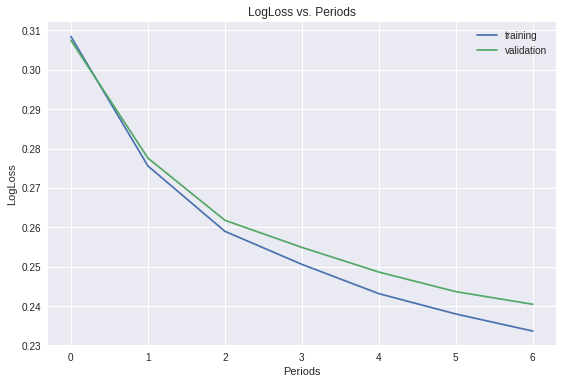

In [10]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    # TWEAK THE REGULARIZATION VALUE BELOW
    regularization_strength=0.1,
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))